In [1]:
### Import libraries and load credentials

# uncomment the following line to install/upgrade the PixieDust library
#! pip install pixiedust --user --upgrade
#! pip install watson_developer_cloud --user
#! pip install pandas
#! pip install matplotlib
#! pip install cloudant
import pixiedust
import json
import datetime
from watson_developer_cloud import ConversationV1
import json

credentials = json.loads(open('../../credentials.json').read())

Pixiedust database opened successfully


In [6]:

### Cloudant Store

from cloudant.client import Cloudant

class cloudant_database(object):
    def __init__(self, db_name):
        self.db_name = db_name
        self.db = None
        self.client = None

    def login(self, username, password, url):
        self.client = Cloudant(username, password, url=url, connect=True)

    def create_database(self):
        self.db = self.client.create_database(self.db_name)

    def list_documents(self, prefix):
        docs = []
        for document in self.db:
            name = document['_id']
            print(name)
            if name and name.startswith(prefix):
                docs.append(document)
        return docs

    def store_json_log(self, data, doc_id):
        data['_id']=doc_id
        try:
            self.db[doc_id]
        except:
            self.db.create_document(data)
            print('document created')
        else:
            print('document exists')


In [7]:
### Setup Conversation instance with local credentials, and login to Cloudant

conversation_local = ConversationV1(
    username=credentials['conversation_local']['username'],
    password=credentials['conversation_local']['password'],
    version='2017-05-26')

workspace_id_local = credentials['conversation_local']['workspace_id']


cdb = cloudant_database('conversation-analysis-' + datetime.datetime.now().strftime('%Y_%m_%d_%H%M%S'))
cdb.login(credentials['cloudant']['username'], credentials['cloudant']['password'], credentials['cloudant']['url'])
cdb.create_database()



In [8]:
### Load conversation using Production credentials and get logs
### Call production logs inside the routine, so that
### prodcution logs are not used anywhere else by mistake


def get_production_logs():
    conversation = ConversationV1(
        username=credentials['conversation']['username'],
        password=credentials['conversation']['password'],
        version='2017-05-26')

    workspace_id = credentials['conversation']['workspace_id']

    logs_response = conversation.list_logs(
      workspace_id = workspace_id,
      page_limit = 1000
    )

    logDump=(json.dumps(logs_response, indent=2))
    #print(logDump)

    inputs=[]
    for log in logs_response["logs"]:
        try:
            inputs.append(log["request"]["input"]['text'].lower())
        except:
            pass
            #print(log["request"]["input"])
    inputs=list(set(inputs))

    timestamp = datetime.datetime.now().strftime('%Y_%m_%d_%H%M%S')
    cdb.store_json_log({"inputs": inputs},'utterances_' + timestamp) # store responses
    return len(inputs)



In [11]:
### Get production Logs

len_logs=get_production_logs()
print('saved logs: ', len_logs)



document created
saved logs:  281


In [144]:
### iterate through input messages for a certain workspace

def iter_messages(inputs, workspace):
    results = {"input": {}}
    print(len(inputs))
    for text in inputs[0:100]: # takes time, iter for just 100 for first run for now
        response = conversation_local.message(
          workspace_id = workspace,
          message_input = {'text': text}
        )
        results["input"][text]={ "intents": response['intents'], "entities": response['entities'] }
    return results
            


In [145]:
utterances=cdb.list_documents("utterances_")[0]['inputs'];
results = iter_messages(utterances, workspace_id_local) #this step takes time


results_intent_info_baseline_2017_11_05_184950
results_workspace_stats_baseline_2017_11_05_184950
utterances_2017_11_05_175830
281


/Users/mamoonraja/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: generator 'CouchDatabase.__iter__' raised StopIteration


In [146]:
### parse stats

def getStats(workspace_id):
    response = conversation_local.get_workspace(workspace_id=workspace_id, export=True)

    intents = response['intents']
    entities = response['entities']
    #print(json.dumps(intents, indent=4, sort_keys=True))

    intents_len =  len(intents)
    dialog_nodes_len = len(response['dialog_nodes'])
    entities_len = len(entities)

    print(intents_len, entities_len)
    examples_len = 0
    intent_info = [];
    timestamp = datetime.datetime.now().strftime('%Y_%m_%d_%H%M%S')


    for intent in intents:
        intent_info.append({'intent' : intent['intent'], 'len_' + timestamp : len(intent['examples']) + 23})
        examples_len += len(intent['examples'])


    values_len = 0
    synonyms_len = 0

    for entity in entities:
      values_len += len(entity['values'])
      for value in entity['values']:
        synonyms_len += (len(value['synonyms']))


    stats = {'ws_id' : workspace_id_local, 'intents' : intent_info}
    stats['ws_stats'] = [{'name' : 'entities_' + timestamp, 'len' : entities_len},
    {'name' : 'values_' + timestamp, 'len' : values_len},
    {'name' : 'synonyms_' + timestamp, "len" : synonyms_len},
    {'name' : 'intents_' + timestamp, 'len' : intents_len},
    {'name' : 'examples_' + timestamp, 'len' : examples_len},
    {'name' : 'dialog_nodes_' + timestamp, 'len' : dialog_nodes_len}]


    return stats, intent_info



In [147]:
### Just looking at intents for now
### Key Value pairs of intent and corresponding confidence value

def parseResults(results, inputs): 
    print(len(inputs))
    intent_stats=[]
    for text in inputs[0:100]:
        if len(results[text]['intents']) > 0:
            intent_stats.append({'intent' : results[text]['intents'][0]['intent'], 'confidence' : results[text]['intents'][0]['confidence']})
    return intent_stats  


In [181]:
### Parse results for workspace, and results after iterating through messages
[results["stats"], intent_info] = getStats(workspace_id_local)
intentResults = parseResults(results["input"], utterances)


25 13
281



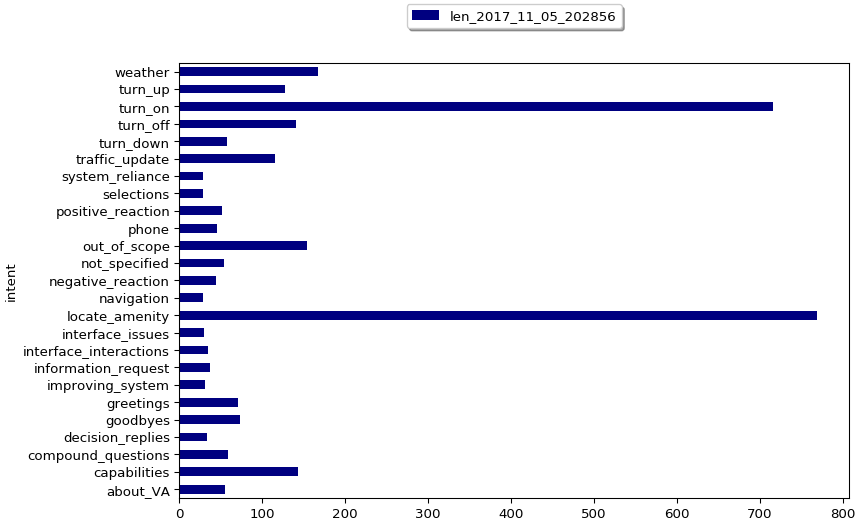

In [149]:
### Import Pandes, and plot results

import pandas as pd
df = pd.DataFrame(intentResults) 

display(df)

df2 = pd.DataFrame(intent_info) # for workspaces

display(df2)

In [150]:
### Upload results to Cloudant
timestamp = datetime.datetime.now().strftime('%Y_%m_%d_%H%M%S')
cdb.store_json_log({"intent_info": intent_info},'results_intent_info_baseline_' + timestamp) # store responses
cdb.store_json_log(results, 'results_workspace_stats_baseline_' + timestamp) # store responses
cdb.store_json_log({"intent_results": intentResults}, 'results_intent_results_baseline_' + timestamp) # store responses


document created
document created
document created


In [151]:
### Update Workspace manually  ** Very very experimental

# Duplicate default workspace and update it
# Intents: 
#  - delete interface_interactions, out_of_scope
# Entities:
#  - delete genre_bad


#Add duplicate workpace id in `credentials.json` and Load credentials again to load duplicate workspace
credentials = json.loads(open('../../credentials.json').read())
workspace_id_local_dup = credentials['conversation_local']['workspace_id_dup']

In [152]:
#itermessages for updated Workspace
results_dup = iter_messages(utterances, workspace_id_local_dup) #this step takes time



281


In [153]:
#getStats for updated workspace
[results_dup["stats"], intent_info_dup] = getStats(workspace_id_local_dup)
intentResults_dup = parseResults(results_dup["input"], utterances)


22 12
281



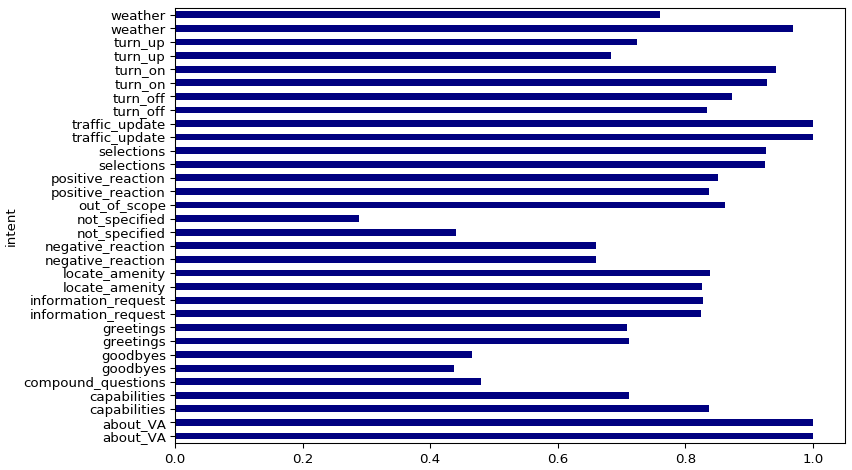

In [186]:
df_dup = pd.DataFrame(intentResults_dup) # for results after itersting through messages
display(df_dup)

df2_dup = pd.DataFrame(intent_info_dup) # for workspace
display(df2_dup)


#compare, not working well
# needs to work on it to show bar chart with plot for same `intent` in different color
df['Key'] = 'key1'
df_dup['Key'] = 'key2'
DF = pd.concat([df, df_dup],keys=['key1','key2'])

display(DF)


In [180]:
### Upload results to Cloudant
timestamp = datetime.datetime.now().strftime('%Y_%m_%d_%H%M%S')
cdb.store_json_log({"intent_info": intent_info},'results_intent_info_rerun_' + timestamp) # store responses
cdb.store_json_log(results, 'results_workspace_stats_rerun_' + timestamp) # store responses
cdb.store_json_log({"intent_results": intentResults}, 'results_intent_results_rerun_' + timestamp) # store responses


document created
document created
document created
